What to do next:


1. Replace simulated alpha with your actual model predictions (maybe see how you can use RL for alpha? Or if it's even worth it)
2. Implement transaction cost modeling
3. Add position limits and sector constraints
4. Set up daily automated execution
5. Implement real-time monitoring and risk alerts
6. Add backtesting framework with performance attribution
7. Consider using robust covariance estimation (I saw something called Ledoit-Wolf shrinkage)
8. Implement dynamic risk aversion based on market conditions (Need to read up more on this)

To make safer, add corporate bonds, maybe more ETFs, Gold, etc.

Use Gurobipy

Tell Micah to get new values for alpha/sigma/mu for the model

Make sure Micah and grace are oriented alongside myself

change this so that the cov matrix takes the log of returns

In [31]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [32]:
# Configuration
TARGET_SECURITIES = ['AAPL', 'TSLA', 'NVDA']  # Your alpha-generating securities
HEDGE_SECURITIES = ['SPY', 'QQQ', 'IWM', 'DIA']  # Large cap ETFs for hedging
ALL_TICKERS = TARGET_SECURITIES + HEDGE_SECURITIES

# Date range for historical data
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=547)  # 1.5 years of data

# Split data: 1 year for training, 6 months for backtesting
SPLIT_DATE = END_DATE - timedelta(days=182)  # 6 months ago

In [33]:
# DATA
print("\n[1] Fetching Historical Price Data from Stooq...")

def fetch_stock_data(tickers, start, end):
    """Fetch stock data from Stooq"""
    data = pd.DataFrame()
    for ticker in tickers:
        try:
            df = web.DataReader(ticker, 'stooq', start, end)
            data[ticker] = df['Close']
            print(f"  ✓ {ticker}: {len(df)} days")
        except Exception as e:
            print(f"  ✗ {ticker}: Error - {e}")
    return data.sort_index()

prices = fetch_stock_data(ALL_TICKERS, START_DATE, END_DATE)

# Split into training and testing periods
prices_train = prices[prices.index < SPLIT_DATE]
prices_test = prices[prices.index >= SPLIT_DATE]

# Calculate returns
returns_train = prices_train.pct_change().dropna()
returns_test = prices_test.pct_change().dropna()

print(f"\nTraining period: {returns_train.index[0].date()} to {returns_train.index[-1].date()} ({len(returns_train)} days)")
print(f"Testing period:  {returns_test.index[0].date()} to {returns_test.index[-1].date()} ({len(returns_test)} days)")

# This is the alpha generation placeholder where we could input different alpha values and balance them
print("\n[2] Generating Alpha Forecasts...")
print("    (In production, replace with your actual alpha model)")

# Simulated alpha - replace with RL model or other alpha generation
# Alpha represents expected excess return over the next period
np.random.seed(42)  # For reproducibility
alpha = pd.Series({
    'AAPL': 0.0015,   # 0.15% expected daily alpha
    'TSLA': 0.0025,   # 0.25% expected daily alpha
    'NVDA': 0.0020,   # 0.20% expected daily alpha
})

print("\nAlpha Forecasts (Expected Daily Returns):")
for ticker, value in alpha.items():
    print(f"  {ticker}: {value:.4f} ({value*252:.2%} annualized)")



[1] Fetching Historical Price Data from Stooq...
  ✓ AAPL: 375 days
  ✓ TSLA: 375 days
  ✓ NVDA: 375 days
  ✓ SPY: 375 days
  ✓ QQQ: 375 days
  ✓ IWM: 375 days
  ✓ DIA: 375 days

Training period: 2024-04-30 to 2025-04-28 (249 days)
Testing period:  2025-04-30 to 2025-10-24 (124 days)

[2] Generating Alpha Forecasts...
    (In production, replace with your actual alpha model)

Alpha Forecasts (Expected Daily Returns):
  AAPL: 0.0015 (37.80% annualized)
  TSLA: 0.0025 (63.00% annualized)
  NVDA: 0.0020 (50.40% annualized)



[3] Computing Covariance Matrix (Sigma)...

Covariance Matrix Shape: (7, 7)
Condition Number: 1732.58
(Lower condition number = more stable matrix)

Correlation Matrix:
       AAPL   TSLA   NVDA    SPY    QQQ    IWM    DIA
AAPL  1.000  0.497  0.428  0.757  0.735  0.566  0.672
TSLA  0.497  1.000  0.467  0.661  0.703  0.559  0.547
NVDA  0.428  0.467  1.000  0.702  0.788  0.489  0.465
SPY   0.757  0.661  0.702  1.000  0.965  0.841  0.909
QQQ   0.735  0.703  0.788  0.965  1.000  0.769  0.803
IWM   0.566  0.559  0.489  0.841  0.769  1.000  0.858
DIA   0.672  0.547  0.465  0.909  0.803  0.858  1.000


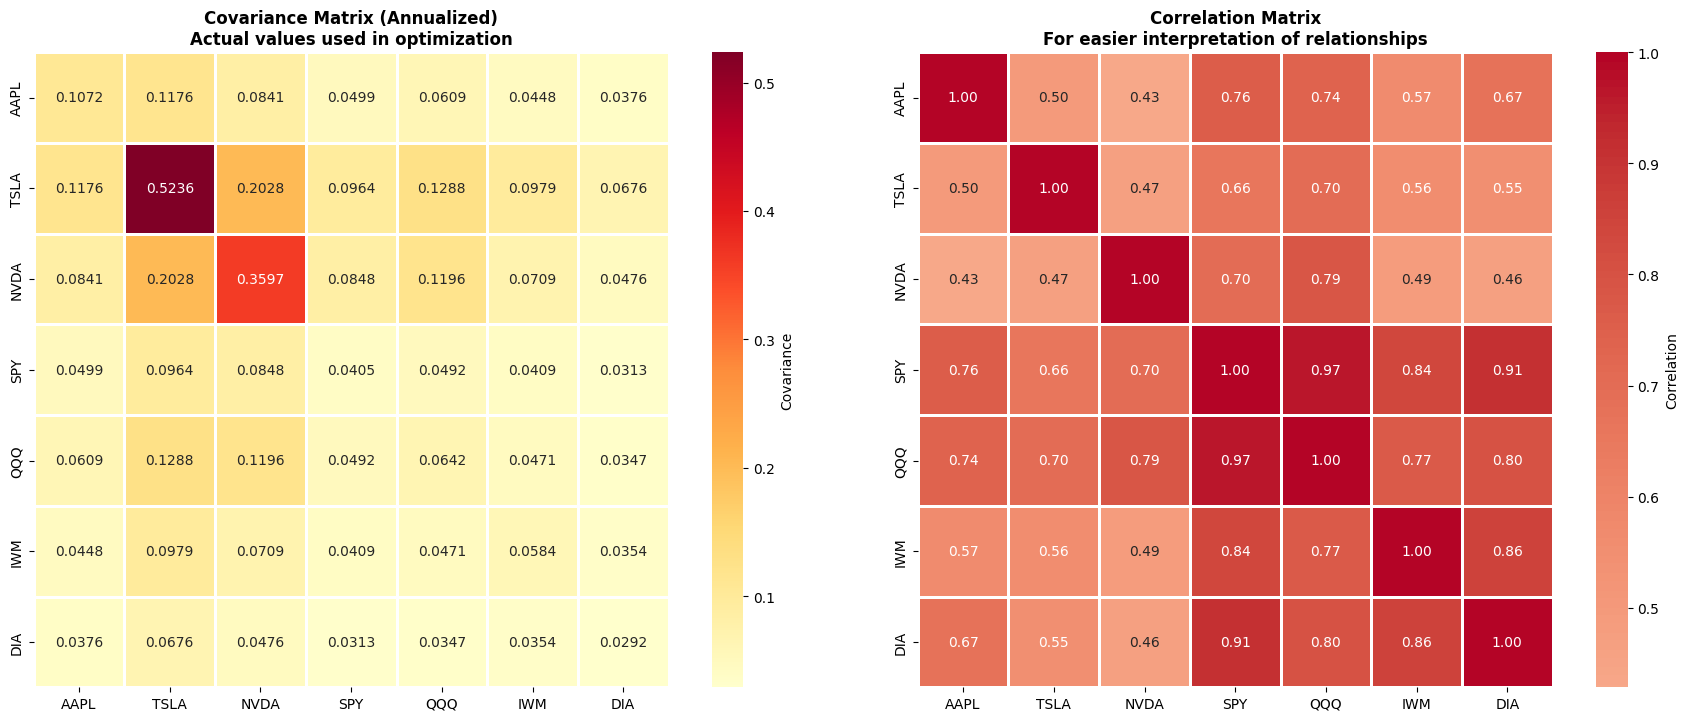

In [34]:
print("\n[3] Computing Covariance Matrix (Sigma)...")

# Calculate covariance matrix from historical returns
cov_matrix = returns_train.cov()

# Annualize for better interpretation (252 trading days)
cov_matrix_annual = cov_matrix * 252

print(f"\nCovariance Matrix Shape: {cov_matrix.shape}")
print(f"Condition Number: {np.linalg.cond(cov_matrix):.2f}")
print("(Lower condition number = more stable matrix)")

# Display correlation matrix for interpretation
corr_matrix = returns_train.corr()
print("\nCorrelation Matrix:")
print(corr_matrix.round(3))

# Visualize both covariance and correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Covariance Matrix (annualized)
ax1 = axes[0]
sns.heatmap(cov_matrix_annual, annot=True, cmap='YlOrRd', 
            fmt='.4f', square=True, linewidths=1, ax=ax1, cbar_kws={'label': 'Covariance'})
ax1.set_title('Covariance Matrix (Annualized)\nActual values used in optimization', 
              fontsize=12, fontweight='bold')

# Correlation Matrix
ax2 = axes[1]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1, ax=ax2, cbar_kws={'label': 'Correlation'})
ax2.set_title('Correlation Matrix\nFor easier interpretation of relationships', 
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [35]:
# RISK ANALYSIS
print("\n[4] Risk Analysis...")

# Calculate volatility (standard deviation)
volatility = returns_train.std() * np.sqrt(252)  # Annualized
print("\nAnnualized Volatility:")
for ticker, vol in volatility.items():
    print(f"  {ticker}: {vol:.2%}")

# Identify which securities have highest correlation with target securities
print("\nHedging Analysis - Correlations with Target Securities:")
for target in TARGET_SECURITIES:
    print(f"\n  {target}:")
    hedge_corrs = corr_matrix.loc[target, HEDGE_SECURITIES].sort_values(ascending=False)
    for hedge, corr in hedge_corrs.items():
        print(f"    {hedge}: {corr:.3f}")


[4] Risk Analysis...

Annualized Volatility:
  AAPL: 32.73%
  TSLA: 72.36%
  NVDA: 59.97%
  SPY: 20.14%
  QQQ: 25.33%
  IWM: 24.18%
  DIA: 17.08%

Hedging Analysis - Correlations with Target Securities:

  AAPL:
    SPY: 0.757
    QQQ: 0.735
    DIA: 0.672
    IWM: 0.566

  TSLA:
    QQQ: 0.703
    SPY: 0.661
    IWM: 0.559
    DIA: 0.547

  NVDA:
    QQQ: 0.788
    SPY: 0.702
    IWM: 0.489
    DIA: 0.465


In [36]:
# PORTFOLIO OPTIMIZATION WITH HEDGING

def portfolio_variance(weights, cov_matrix):
    """Calculate portfolio variance"""
    return weights.T @ cov_matrix @ weights

def portfolio_return(weights, alpha_vec):
    """Calculate expected portfolio return"""
    return weights.T @ alpha_vec

def optimize_portfolio(alpha, cov_matrix, risk_aversion=2.0, max_leverage=1.5):
    """
    Optimize portfolio using mean-variance optimization
    
    Risk aversion parameter:
    - Higher value = more conservative (lower risk, lower return)
    - Lower value = more aggressive (higher risk, higher return)
    """
    n = len(alpha)
    
    # Extend alpha vector with zeros for hedge instruments
    alpha_extended = np.zeros(len(ALL_TICKERS))
    for i, ticker in enumerate(ALL_TICKERS):
        if ticker in alpha.index:
            alpha_extended[i] = alpha[ticker]
    
    # Objective: maximize return - risk_aversion * variance
    def objective(w):
        ret = portfolio_return(w, alpha_extended)
        var = portfolio_variance(w, cov_matrix.values)
        return -(ret - risk_aversion * var)  # Negative for minimization
    
    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}  # Fully invested
    ]
    
    # Bounds: allow short selling but limit leverage
    bounds = [(-max_leverage, max_leverage) for _ in range(len(ALL_TICKERS))]
    
    # Initial guess: equal weight on target securities
    w0 = np.zeros(len(ALL_TICKERS))
    for i, ticker in enumerate(ALL_TICKERS):
        if ticker in TARGET_SECURITIES:
            w0[i] = 1.0 / len(TARGET_SECURITIES)
    
    # Optimize
    result = minimize(objective, w0, method='SLSQP', bounds=bounds, 
                     constraints=constraints, options={'maxiter': 1000})
    
    return result

# Run optimization
result = optimize_portfolio(alpha, cov_matrix, risk_aversion=2.0, max_leverage=1.5)
optimal_weights = pd.Series(result.x, index=ALL_TICKERS)


In [37]:
# DISPLAY OPTIMAL PORTFOLIO
print("\n[6] Optimal Portfolio Weights:")
print("=" * 50)

# Separate long and short positions
long_positions = optimal_weights[optimal_weights > 0.001].sort_values(ascending=False)
short_positions = optimal_weights[optimal_weights < -0.001].sort_values()

print("\nLONG POSITIONS:")
for ticker, weight in long_positions.items():
    security_type = "Target" if ticker in TARGET_SECURITIES else "Hedge"
    print(f"  {ticker:6s} [{security_type:6s}]: {weight:7.2%}")

if len(short_positions) > 0:
    print("\nSHORT POSITIONS (Hedges):")
    for ticker, weight in short_positions.items():
        security_type = "Target" if ticker in TARGET_SECURITIES else "Hedge"
        print(f"  {ticker:6s} [{security_type:6s}]: {weight:7.2%}")

# Calculate portfolio metrics
alpha_extended = np.zeros(len(ALL_TICKERS))
for i, ticker in enumerate(ALL_TICKERS):
    if ticker in alpha.index:
        alpha_extended[i] = alpha[ticker]

portfolio_return_daily = optimal_weights.values @ alpha_extended
portfolio_var = optimal_weights.values @ cov_matrix.values @ optimal_weights.values
portfolio_vol = np.sqrt(portfolio_var * 252)  # Annualized

print("\n" + "=" * 50)
print("PORTFOLIO METRICS:")
print(f"  Expected Daily Return:  {portfolio_return_daily:.4f} ({portfolio_return_daily*252:.2%} ann.)")
print(f"  Portfolio Volatility:   {portfolio_vol:.2%} (annualized)")
print(f"  Sharpe Ratio (estimated):    {(portfolio_return_daily*252) / portfolio_vol:.2f}")
print(f"  Gross Leverage:         {np.abs(optimal_weights).sum():.2f}x")
print(f"  Net Exposure:           {optimal_weights.sum():.2%}")

# RISK
print("\n[7] Risk Contribution Analysis...")

# Calculate marginal contribution to risk
marginal_risk = cov_matrix.values @ optimal_weights.values
risk_contribution = optimal_weights.values * marginal_risk
risk_contribution_pct = risk_contribution / risk_contribution.sum()

risk_df = pd.DataFrame({
    'Weight': optimal_weights,
    'Risk Contribution': risk_contribution,
    'Risk %': risk_contribution_pct * 100
}).sort_values('Risk Contribution', ascending=False)

print("\nRisk Contribution by Security:")
print(risk_df.round(4))




[6] Optimal Portfolio Weights:

LONG POSITIONS:
  AAPL   [Target]: 150.00%
  NVDA   [Target]:  32.72%
  TSLA   [Target]:  25.86%
  DIA    [Hedge ]:  21.89%

SHORT POSITIONS (Hedges):
  QQQ    [Hedge ]: -82.49%
  SPY    [Hedge ]: -31.07%
  IWM    [Hedge ]: -16.92%

PORTFOLIO METRICS:
  Expected Daily Return:  0.0036 (89.49% ann.)
  Portfolio Volatility:   49.70% (annualized)
  Sharpe Ratio (estimated):    1.80
  Gross Leverage:         3.61x
  Net Exposure:           100.00%

[7] Risk Contribution Analysis...

Risk Contribution by Security:
      Weight  Risk Contribution   Risk %
AAPL  1.5000             0.0009  93.2292
TSLA  0.2586             0.0002  25.1566
NVDA  0.3272             0.0002  22.4736
DIA   0.2189             0.0000   4.5549
IWM  -0.1692            -0.0000  -4.2508
SPY  -0.3107            -0.0001  -9.3403
QQQ  -0.8249            -0.0003 -31.8231


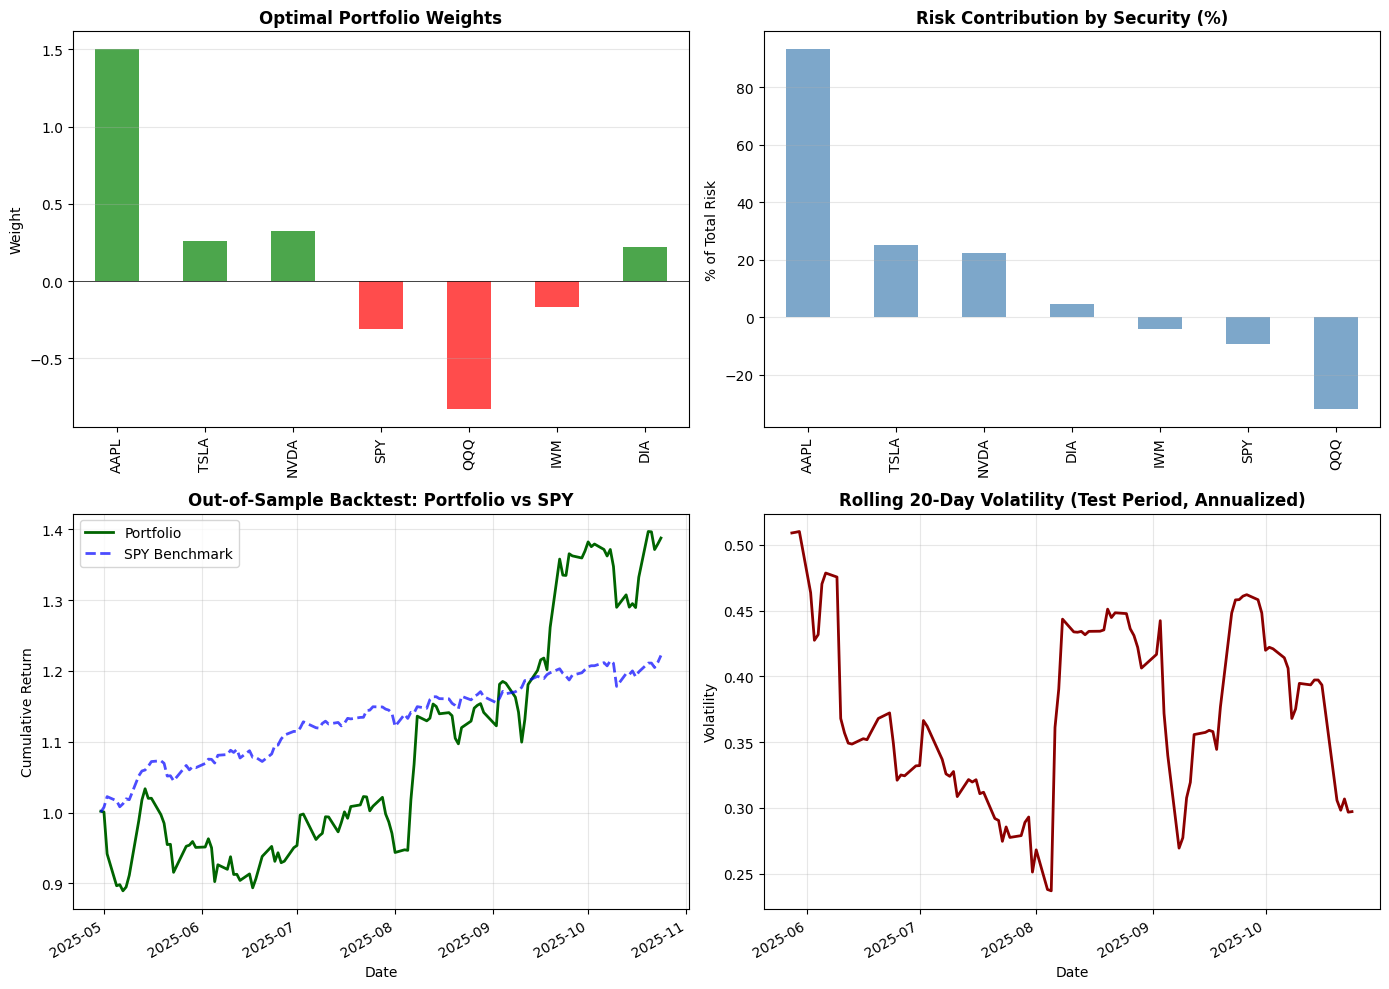


OUT-OF-SAMPLE BACKTEST RESULTS (Test Period):
Portfolio Total Return:  +38.76%
SPY Total Return:        +22.18%
Excess Return:           +16.58%
Portfolio Sharpe Ratio:  1.91
SPY Sharpe Ratio:        3.61


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Portfolio Weights
ax1 = axes[0, 0]
colors = ['green' if w > 0 else 'red' for w in optimal_weights]
optimal_weights.plot(kind='bar', ax=ax1, color=colors, alpha=0.7)
ax1.set_title('Optimal Portfolio Weights', fontsize=12, fontweight='bold')
ax1.set_ylabel('Weight')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Risk Contribution
ax2 = axes[0, 1]
risk_df['Risk %'].plot(kind='bar', ax=ax2, color='steelblue', alpha=0.7)
ax2.set_title('Risk Contribution by Security (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('% of Total Risk')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Cumulative Returns on TEST data (out-of-sample backtest)
ax3 = axes[1, 0]
portfolio_returns_test = (returns_test @ optimal_weights)
cumulative_returns_test = (1 + portfolio_returns_test).cumprod()
cumulative_returns_test.plot(ax=ax3, linewidth=2, color='darkgreen', label='Portfolio')

# Also plot SPY as benchmark
spy_returns_test = returns_test['SPY']
spy_cumulative = (1 + spy_returns_test).cumprod()
spy_cumulative.plot(ax=ax3, linewidth=2, color='blue', alpha=0.7, label='SPY Benchmark', linestyle='--')

ax3.set_title('Out-of-Sample Backtest: Portfolio vs SPY', fontsize=12, fontweight='bold')
ax3.set_ylabel('Cumulative Return')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Rolling Volatility on TEST data
ax4 = axes[1, 1]
rolling_vol_test = portfolio_returns_test.rolling(window=20).std() * np.sqrt(252)
rolling_vol_test.plot(ax=ax4, linewidth=2, color='darkred')
ax4.set_title('Rolling 20-Day Volatility (Test Period, Annualized)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Volatility')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

total_return_portfolio = (cumulative_returns_test.iloc[-1] - 1) * 100
total_return_spy = (spy_cumulative.iloc[-1] - 1) * 100
sharpe_test = portfolio_returns_test.mean() / portfolio_returns_test.std() * np.sqrt(252)
sharpe_spy = spy_returns_test.mean() / spy_returns_test.std() * np.sqrt(252)

print(f"Portfolio Total Return:  {total_return_portfolio:+.2f}%")
print(f"SPY Total Return:        {total_return_spy:+.2f}%")
print(f"Excess Return:           {total_return_portfolio - total_return_spy:+.2f}%")
print(f"Portfolio Sharpe Ratio:  {sharpe_test:.2f}")
print(f"SPY Sharpe Ratio:        {sharpe_spy:.2f}")
